In [2]:
# Data Preprocessing
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
from torchvision import models, transforms
from PIL import Image


#Image Processing import os
from pathlib import Path 
import joblib, time

#Machine Learning
from sklearn.neighbors import NearestNeighbors 
from sklearn.metrics.pairwise import cosine_similarity

#Settings 
import warnings
warnings. filterwarnings("ignore") 
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

#Set Random seeds 
np.random.seed(42)
torch.manual_seed(42)


In [8]:
import cv2
from rembg import remove
import os
from tqdm import tqdm
import random

In [ ]:
from rembg import remove, new_session

# ---------------- CONFIG ---------------- #
SOURCE_FOLDER = "images"
OUTPUT_FOLDER = "processed_images_clean"
MAX_IMAGES = 5000
TARGET_SIZE = 224
RANDOM_SEED = 42

os.makedirs(OUTPUT_FOLDER, exist_ok=True)


print("Initializing AI models...")
rembg_session = new_session("u2net_human_seg") 

# HELPER FUNCTIONS

def remove_background_and_whiten(pil_img, session):
    no_bg_rgba = remove(pil_img, session=session)  
    
    white_bg = Image.new("RGB", no_bg_rgba.size, (255, 255, 255))
    white_bg.paste(no_bg_rgba, mask=no_bg_rgba.split()[3])
    return white_bg

def resize_with_padding(img, target_size=224):
    img.thumbnail((target_size, target_size), Image.LANCZOS)

    padded_img = Image.new("RGB", (target_size, target_size), (255, 255, 255))
    padded_img.paste(
        img,
        ((target_size - img.width) // 2, (target_size - img.height) // 2)
    )
    return padded_img

# MAIN PIPELINE

image_files = [f for f in os.listdir(SOURCE_FOLDER) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
random.seed(RANDOM_SEED)
random.shuffle(image_files)
image_files = image_files[:MAX_IMAGES]

print(f"Processing {len(image_files)} images...")

for img_name in tqdm(image_files):
    input_path = os.path.join(SOURCE_FOLDER, img_name)
    try:
        with Image.open(input_path) as img:
            img = img.convert("RGB")
            
            # Remove BG
            clean_img = remove_background_and_whiten(img, rembg_session)
            
            # Resize & Pad
            final_img = resize_with_padding(clean_img, TARGET_SIZE)

            # Save
            save_name = os.path.splitext(img_name)[0] + ".png"
            final_img.save(os.path.join(OUTPUT_FOLDER, save_name), format="PNG")
            
    except Exception as e:
        print(f"Skip {img_name}: {e}")

print("✅ Preprocessing complete!")

Initializing AI models...


100%|████████████████████████████████████████| 176M/176M [00:00<00:00, 128GB/s]


Processing 5000 images...


100%|██████████| 5000/5000 [09:40<00:00,  8.61it/s]

✅ Preprocessing complete!


In [ ]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using Apple Silicon GPU (MPS) 🚀")

elif torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using NVIDIA GPU (CUDA) 🚀")

else:
    device = torch.device("cpu")
    print("No GPU found, using CPU.")


# Load Pre-trained ResNet-18
model = models.resnet18(weights='IMAGENET1K_V1')
# Remove the final classification layer (fc) to get the 512-D embedding
model = nn.Sequential(*list(model.children())[:-1])
model = model.to(device)
model.eval()

Using Apple Silicon GPU (MPS) 🚀
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /Users/rahulchoudhary/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100.0%


Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

In [ ]:

import pickle


transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Process the "Clean" Folder
IMAGE_DIR = "processed_images_clean"
all_embeddings = []
image_names = []

print(f"Extracting features using {device}...")

with torch.no_grad():
    for img_name in tqdm(os.listdir(IMAGE_DIR)):
        if not img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
            continue
            
        img_path = os.path.join(IMAGE_DIR, img_name)
        try:
            img = Image.open(img_path).convert('RGB')
            img_t = transform(img).unsqueeze(0).to(device)
            
            # Forward pass to get embedding
            embedding = model(img_t)
            embedding = embedding.cpu().numpy().flatten() # Convert to 512-D vector
            
            all_embeddings.append(embedding)
            image_names.append(img_name)
        except Exception as e:
            print(f"Error on {img_name}: {e}")

# Save everything for the next stage
data = {"embeddings": np.array(all_embeddings), "names": image_names}
with open("feature_vectors.pkl", "wb") as f:
    pickle.dump(data, f)

print("✅ Embeddings saved to feature_vectors.pkl!")

Extracting features using mps...


100%|██████████| 5000/5000 [01:08<00:00, 73.31it/s] 


✅ Embeddings saved to feature_vectors.pkl!


In [15]:
def show_images(image_paths, titles=None, figsize=(15, 5)):
    plt.figure(figsize=figsize)

    for i, img_path in enumerate(image_paths):
        plt.subplot(1, len(image_paths), i + 1)
        img = Image.open(img_path)
        plt.imshow(img)
        plt.axis("off")

        if titles:
            plt.title(titles[i], fontsize=10)

    plt.show()

In [16]:
# Load the data
with open("feature_vectors.pkl", "rb") as f:
    data = pickle.load(f)

embeddings = data["embeddings"]
filenames = data["names"]

# Initialize KNN
# Metric='cosine' is usually better for high-dimensional embeddings than 'euclidean'
knn = NearestNeighbors(n_neighbors=6, metric='cosine', algorithm='brute')
knn.fit(embeddings)

NearestNeighbors(algorithm='brute', metric='cosine', n_neighbors=6)

Recommendations for 15502242.png:
1: 19340606.png (Similarity: 0.9069)
2: 12668146.png (Similarity: 0.8875)
3: 18647784.png (Similarity: 0.8829)
4: 2196409.png (Similarity: 0.8812)
5: 1730223.png (Similarity: 0.8800)


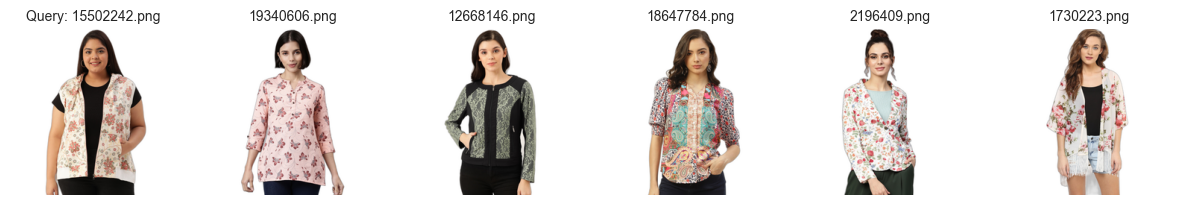

In [25]:
# Example: Recommend for the first image in your folder
query_index = 70
distances, indices = knn.kneighbors([embeddings[query_index]])

image_paths = []
titles = []

image_folder = "processed_images_clean"  # or original image folder

# Query image
image_paths.append(os.path.join(image_folder, filenames[query_index]))
titles.append(f"Query: {filenames[query_index]}")


print(f"Recommendations for {filenames[query_index]}:")
for i in range(1, len(indices[0])): # Start from 1 to skip the query image itself
    idx = indices[0][i]
    print(f"{i}: {filenames[idx]} (Similarity: {1-distances[0][i]:.4f})")
    image_paths.append(os.path.join(image_folder, filenames[idx]))
    titles.append(filenames[idx])

# Display
show_images(image_paths, titles)